In [78]:
# 读取csv文件
import pandas as pd
from tqdm import tqdm

# 读取CSV文件
df = pd.read_csv('../dataset/DeepFashion-MultiModal/labels_front.csv')
df["path"] = df["path"].apply(lambda x: "../dataset/DeepFashion-MultiModal/selected_images/"+x)
df

,image_id,caption,path,gender,product_type,product_id,image_type
0,MEN-Denim-id_00000089-28_1_front,This gentleman is wearing a medium-sleeve shir...,../dataset/DeepFashion-MultiModal/selected_ima...,MEN,Denim,id_00000089,front
1,MEN-Denim-id_00000265-01_1_front,This person is wearing a short-sleeve shirt wi...,../dataset/DeepFashion-MultiModal/selected_ima...,MEN,Denim,id_00000265,front
2,MEN-Denim-id_00000313-01_1_front,The gentleman is wearing a short-sleeve T-shir...,../dataset/DeepFashion-MultiModal/selected_ima...,MEN,Denim,id_00000313,front
3,MEN-Denim-id_00000516-01_1_front,The person wears a sleeveless tank shirt with ...,../dataset/DeepFashion-MultiModal/selected_ima...,MEN,Denim,id_00000516,front
4,MEN-Denim-id_00000750-01_1_front,"His sweater has long sleeves, cotton fabric an...",../dataset/DeepFashion-MultiModal/selected_ima...,MEN,Denim,id_00000750,front
...,...,...,...,...,...,...,...
12273,WOMEN-Tees_Tanks-id_00007970-01_1_front,This lady is wearing a short-sleeve shirt with...,../dataset/DeepFashion-MultiModal/selected_ima...,WOMEN,Tees_Tanks,id_00007970,front
12274,WOMEN-Tees_Tanks-id_00007976-01_1_front,"Her tank top has sleeves cut off, cotton fabri...",../dataset/DeepFashion-MultiModal/selected_ima...,WOMEN,Tees_Tanks,id_00007976,front
12275,WOMEN-Tees_Tanks-id_00007979-03_1_front,The female wears a tank tank shirt with graphi...,../dataset/DeepFashion-MultiModal/selected_ima...,WOMEN,Tees_Tanks,id_00007979,front
12276,WOMEN-Tees_Tanks-id_00007979-04_1_front,The tank top this person wears has sleeves cut...,../dataset/DeepFashion-MultiModal/selected_ima...,WOMEN,Tees_Tanks,id_00007979,front


In [79]:
print("\n数据基本信息：")
print(df.info())

# 显示数据形状
print(f"\n数据形状：{df.shape}")


数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12278 entries, 0 to 12277
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      12278 non-null  object
 1   caption       12278 non-null  object
 2   path          12278 non-null  object
 3   gender        12278 non-null  object
 4   product_type  12278 non-null  object
 5   product_id    12278 non-null  object
 6   image_type    12278 non-null  object
dtypes: object(7)
memory usage: 671.6+ KB
None

数据形状：(12278, 7)


In [80]:
from PIL import Image
from torch.utils.data import Dataset

class FashionDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor  # 加入 processor
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['path']
        text = row['caption']
        
        # 读取并转换图片
        image = Image.open(image_path).convert('RGB')
        
        # 使用 processor 处理图像和文本
        encoding = self.processor(
            images=image,
            text=text,
            padding='max_length',         # 或 "do_not_pad"，依据模型设置
            return_tensors='pt'
        )
        
        # 去除 batch 维度（默认是 batch_size=1 的形式）
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        
        return encoding

图片路径: ../dataset/DeepFashion-MultiModal/selected_images/MEN-Denim-id_00000089-28_1_front.jpg
文本描述:This gentleman is wearing a medium-sleeve shirt with pure color patterns. The shirt is with cotton fabric and its neckline is lapel. This gentleman wears a long trousers. The trousers are with cotton fabric and solid color patterns.


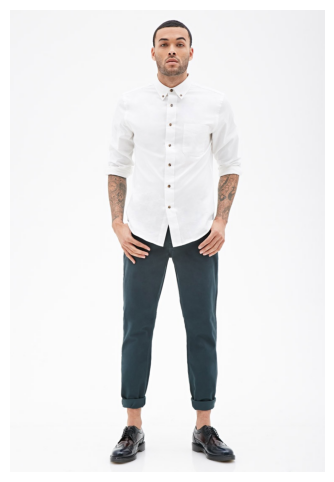

In [81]:
path = df["path"][0]
print("图片路径:", path)

# 读取并展示图片
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 读取图片
img = mpimg.imread(path)

print("文本描述:"+df["caption"][0])

# 创建图形
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # 隐藏坐标轴
plt.show()


In [82]:
import torch
from torch.optim import AdamW
from transformers import BlipForImageTextRetrieval
blip_path = "/root/autodl-fs/blip-image-captioning-base/"

model = BlipForImageTextRetrieval.from_pretrained(blip_path).cuda()
model

Some weights of BlipForImageTextRetrieval were not initialized from the model checkpoint at /root/autodl-fs/blip-image-captioning-base/ and are newly initialized: ['itm_head.bias', 'itm_head.weight', 'text_encoder.embeddings.LayerNorm.bias', 'text_encoder.embeddings.LayerNorm.weight', 'text_encoder.embeddings.position_embeddings.weight', 'text_encoder.embeddings.word_embeddings.weight', 'text_encoder.encoder.layer.0.attention.output.LayerNorm.bias', 'text_encoder.encoder.layer.0.attention.output.LayerNorm.weight', 'text_encoder.encoder.layer.0.attention.output.dense.bias', 'text_encoder.encoder.layer.0.attention.output.dense.weight', 'text_encoder.encoder.layer.0.attention.self.key.bias', 'text_encoder.encoder.layer.0.attention.self.key.weight', 'text_encoder.encoder.layer.0.attention.self.query.bias', 'text_encoder.encoder.layer.0.attention.self.query.weight', 'text_encoder.encoder.layer.0.attention.self.value.bias', 'text_encoder.encoder.layer.0.attention.self.value.weight', 'text_en

BlipForImageTextRetrieval(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, 

In [83]:
from PIL import Image
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(blip_path, use_fast=True)
image_path = df["path"][0]
text = df["caption"][0]
image = Image.open(image_path).convert('RGB')
inputs = processor(
    images=image,
    text=text,
    return_tensors="pt"
).to("cuda")

In [84]:
# 4. 获取原始的768维特征(importent)
with torch.no_grad():
    # 获取视觉特征(768维)
    vision_outputs = model.vision_model(inputs.pixel_values)
    vision_embeds = vision_outputs.last_hidden_state[:, 0, :]  # [batch_size, 768]
    
    # 获取文本特征(768维)
    text_outputs = model.text_encoder(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask
    )
    text_embeds = text_outputs.last_hidden_state[:, 0, :]  # [batch_size, 768]
    
    # 使用投影层将特征从768维映射到256维
    vision_projected = model.vision_proj(vision_embeds)  # [batch_size, 256]
    text_projected = model.text_proj(text_embeds)      # [batch_size, 256]
    # text_projected和text_embeds都是tensor类型，请计算余弦相似度
    
    # 计算余弦相似度
    cosine_similarity = torch.nn.functional.cosine_similarity(vision_projected, text_projected, dim=1)
    print(cosine_similarity)

tensor([0.0800], device='cuda:0')
